# Лабораторная работа 5

## Цель 
Распознавание объектов на фотографиях (Object Recognition in Photographs) 
CIFAR-10  (классификация  небольших  изображений  по  десяти  классам:  самолет, 
автомобиль, птица, кошка, олень, собака, лягушка, лошадь, корабль и грузовик). 

## Задачи 
- Ознакомиться со сверточными нейронными сетями 
- Изучить построение модели в Keras в функциональном виде 
- Изучить работу слоя разреживания (Dropout) 

В качестве практической части построим глубокую сверточную нейронную сеть и применим 
ее к классификации изображений из набора CIFAR-10

In [1]:
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input,  Convolution2D,  MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
import numpy as np

2024-12-10 22:20:47.548831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- batch_size  —  количество обучающих образцов, обрабатываемых одновременно за одну 
итерацию алгоритма градиентного спуска; 
- num_epochs — количество  итераций  обучающего  алгоритма  по  всему  обучающему 
множеству; 
- kernel_size — размер ядра в сверточных слоях; 
- pool_size — размер подвыборки в слоях подвыборки; 
- сonv_depth — количество ядер в сверточных слоях; 
- drop_prob (dropout probability) — мы  будем  применять  dropout  после  каждого  слоя 
подвыборки, а также после полносвязного слоя; 
- hidden_size — количество нейронов в полносвязном слое MLP.

In [2]:
batch_size = 32  # in  each  iteration,  we  consider  32  training examples at once
num_epochs = 100  # we iterate 200 times over the entire training
set
kernel_size = 3  # we will use 3x3 kernels throughout
pool_size = 2  # we will use 2x2 pooling throughout
conv_depth_1 = 32  # we will initially have 32 kernels per conv.
# layer...
conv_depth_2 = 64  # ...switching to 64 after the first pooling
# layer
drop_prob_1 = 0.25  # dropout after pooling with probability 0.25
drop_prob_2 = 0.5  # dropout in the dense layer with probability
0.5
hidden_size = 512  # the dense layer will have 512 neurons

In [3]:
(X_train,  y_train),  (X_test,  y_test) = cifar10.load_data()  # fetch CIFAR-10 data
# there are 50000 training examples in CIFAR-10
num_train, depth, height, width = X_train.shape
num_test = X_test.shape[0]  # there  are  10000  test  examples  in CIFAR-10
num_classes = np.unique(y_train).shape[0]  # there are 10 image classes
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= np.max(X_train)  # Normalise data to [0, 1] range
X_test /= np.max(X_train)  # Normalise data to [0, 1] range
Y_train = np_utils.to_categorical(
    y_train,  num_classes)  # One-hot encode the labels
Y_test = np_utils.to_categorical(
    y_test, num_classes)  # One-hot encode the labels

In [4]:
inp = Input(shape=(depth, height, width))  # N.B. depth goes first in Keras
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1,  kernel_size,
                       kernel_size, padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1,  kernel_size,  kernel_size,
                       padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2,  kernel_size,  kernel_size,
                       padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2,  kernel_size,  kernel_size,
                       padding='same', activation='relu')(conv_3)
# pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(conv_4)
# Now flatten to 1D, apply Dense -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden = Dense(hidden_size, activation='relu')(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation='softmax')(drop_3)
# To define a model, just specify its input and output layers
model_kernel = Model(inp, out)
model_kernel.compile(loss='categorical_crossentropy',  # using the cross-entropy loss function
                     optimizer='adam',  # using the Adam optimiser
                     metrics=['accuracy'])  # reporting the accuracy
history_with_Dropout = model_kernel.fit(X_train, Y_train,  # Train the model using the training set...
                                        batch_size=batch_size, epochs=num_epochs,
                                        verbose=1, validation_split=0.1)  # ...holding out 10% of the data for validation
# Evaluate the trained model on the test set!
model_kernel.evaluate(X_test, Y_test, verbose=1)

2024-12-10 22:20:52.083411: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-10 22:20:52.083590: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-10 22:20:52.083608: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-10 22:20:52.083689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 22:20:52.083738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-12-10 22:20:55.061288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-10 22:20:55.210396: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1407/1407 [==============================] - ETA: 0s - loss: 1.8937 - accuracy: 0.2862

2024-12-10 22:21:27.875871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 36s 24ms/step - loss: 1.8937 - accuracy: 0.2862 - val_loss: 1.6519 - val_accuracy: 0.3758
Epoch 2/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.6460 - accuracy: 0.3872 - val_loss: 1.5636 - val_accuracy: 0.4242
Epoch 3/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5796 - accuracy: 0.4179 - val_loss: 1.5069 - val_accuracy: 0.4524
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5358 - accuracy: 0.4368 - val_loss: 1.4526 - val_accuracy: 0.4542
Epoch 5/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1.4970 - accuracy: 0.4547 - val_loss: 1.4073 - val_accuracy: 0.4854
Epoch 6/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1.4748 - accuracy: 0.4590 - val_loss: 1.4056 - val_accuracy: 0.4904
Epoch 7/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1.4509 - accuracy: 0.4694 - val_loss: 1.3940 - val_

[12103921.0, 0.3407000005245209]

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Путь к изображению
image_path = "horse.jpg"

# Загрузка изображения и изменение его размера под вход модели
img = image.load_img(image_path, target_size=(32, 32))
img_array = image.img_to_array(img)  # Преобразование в массив NumPy
img_array = img_array.astype('float32') / 255.0  # Нормализация
img_array = np.expand_dims(img_array, axis=0)  # Добавляем измерение для пакета

# Проверка формы
print(f"Shape of input array: {img_array.shape}")  # Должно быть (1, 32, 32, 3)

# Используем модель для предсказания
predictions = model_kernel.predict(img_array)

# Преобразуем предсказание в метку класса
predicted_class = np.argmax(predictions)

class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"Predicted class: {class_names[predicted_class]}")

Shape of input array: (1, 32, 32, 3)


2024-12-11 02:05:55.560105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 911ms/step
Predicted class: horse


Удаляем дропаут слои

In [8]:
inp = Input(shape=(depth, height, width))  # N.B. depth goes first in Keras
# Conv [32] -> Conv [32] -> Pool
conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size,
                       padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, kernel_size, kernel_size,
                       padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)

# Conv [64] -> Conv [64] -> Pool
conv_3 = Convolution2D(conv_depth_2, kernel_size, kernel_size,
                       padding='same', activation='relu')(pool_1)
conv_4 = Convolution2D(conv_depth_2, kernel_size, kernel_size,
                       padding='same', activation='relu')(conv_3)

# Flatten -> Dense -> Softmax
flat = Flatten()(conv_4)
hidden = Dense(hidden_size, activation='relu')(flat)
out = Dense(num_classes, activation='softmax')(
    hidden)  # Используем выход напрямую

# Define model
model_without_Dropout = Model(inp, out)
model_without_Dropout.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_without_Dropout = model_without_Dropout.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.1
)

# Evaluate the model
model_without_Dropout.evaluate(X_test, Y_test, verbose=1)

Epoch 1/30


2024-12-10 23:46:05.428518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-10 23:46:05.509899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1407/1407 [==============================] - ETA: 0s - loss: 1.7924 - accuracy: 0.3270

2024-12-10 23:46:33.979007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 31s 22ms/step - loss: 1.7924 - accuracy: 0.3270 - val_loss: 1.6081 - val_accuracy: 0.4042
Epoch 2/30
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5625 - accuracy: 0.4149 - val_loss: 1.5185 - val_accuracy: 0.4312
Epoch 3/30
1407/1407 [==============================] - 29s 20ms/step - loss: 1.4561 - accuracy: 0.4625 - val_loss: 1.4579 - val_accuracy: 0.4754
Epoch 4/30
1407/1407 [==============================] - 30s 21ms/step - loss: 1.3908 - accuracy: 0.4907 - val_loss: 1.3745 - val_accuracy: 0.4944
Epoch 5/30
1407/1407 [==============================] - 30s 21ms/step - loss: 1.3506 - accuracy: 0.5052 - val_loss: 1.3507 - val_accuracy: 0.5066
Epoch 6/30
1407/1407 [==============================] - 29s 21ms/step - loss: 1.3228 - accuracy: 0.5190 - val_loss: 1.3868 - val_accuracy: 0.4968
Epoch 7/30
1407/1407 [==============================] - 29s 20ms/step - loss: 1.3296 - accuracy: 0.5176 - val_loss: 1.4586 - val_accura

[9106185.0, 0.15919999778270721]

In [9]:
import matplotlib.pyplot as plt


def plot_model_comparison(histories, model_names=None):
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(histories))]

    for i, history in enumerate(histories):
        plt.plot(history.history['loss'],
                 label=f'{model_names[i]} - Training Loss')
        # plt.plot(history.history['val_loss'],
        #  label=f'{model_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Comparison of Training and Validation Loss')
    plt.legend()
    plt.show()

    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'],
                 label=f'{model_names[i]} - Training Accuracy')
        # plt.plot(history.history['val_accuracy'],
        #          label=f'{model_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Training and Validation Accuracy')
    plt.legend()
    plt.show()

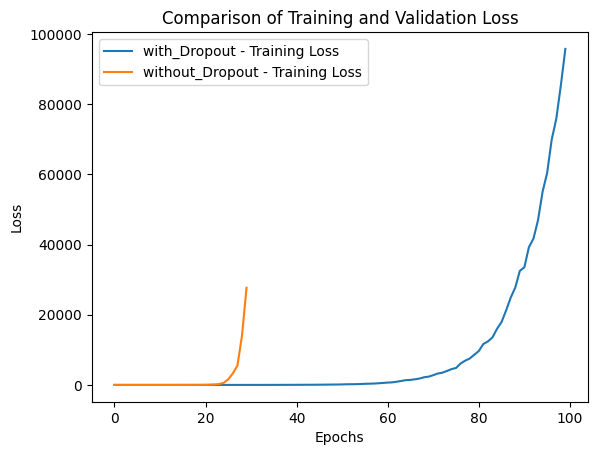

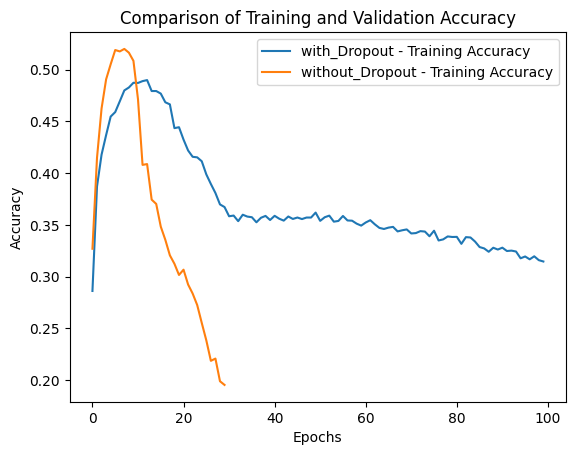

In [10]:
plot_model_comparison(histories=[history_with_Dropout, history_without_Dropout], model_names=[
                      "with_Dropout", "without_Dropout"])

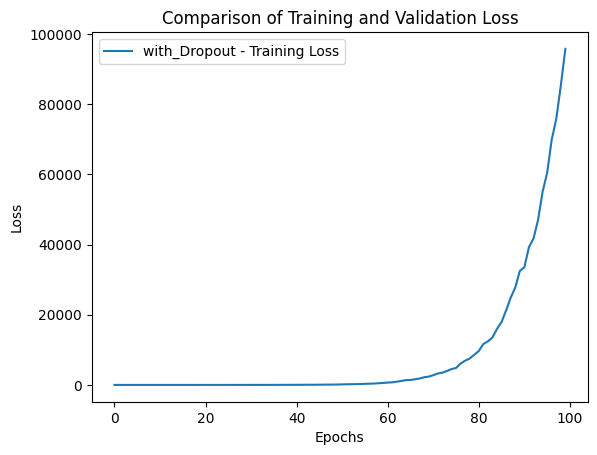

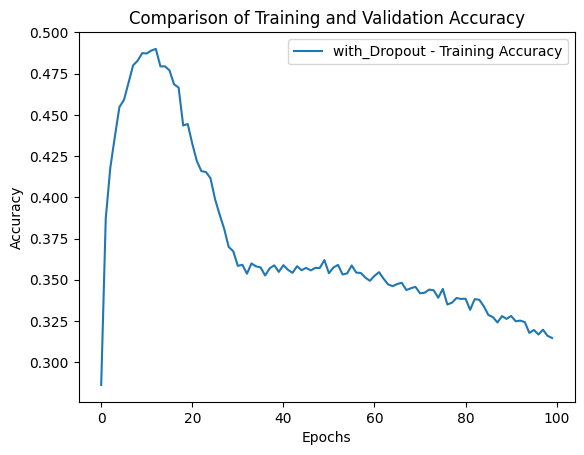

In [11]:
plot_model_comparison(histories=[history_with_Dropout], model_names=[
                      "with_Dropout"])


>>> Training with kernel size: 2x2 <<<

Epoch 1/20


2024-12-11 00:00:44.472517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 00:00:44.570431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1407/1407 [==============================] - ETA: 0s - loss: 1.5759 - accuracy: 0.4242

2024-12-11 00:01:21.417501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 40s 27ms/step - loss: 1.5759 - accuracy: 0.4242 - val_loss: 1.2010 - val_accuracy: 0.5730
Epoch 2/20
1407/1407 [==============================] - 40s 28ms/step - loss: 1.2389 - accuracy: 0.5660 - val_loss: 1.0591 - val_accuracy: 0.6186
Epoch 3/20
1407/1407 [==============================] - 39s 28ms/step - loss: 1.3864 - accuracy: 0.5638 - val_loss: 1.2837 - val_accuracy: 0.5932
Epoch 4/20
1407/1407 [==============================] - 38s 27ms/step - loss: 2.4225 - accuracy: 0.5138 - val_loss: 2.0303 - val_accuracy: 0.5676
Epoch 5/20
1407/1407 [==============================] - 38s 27ms/step - loss: 6.0821 - accuracy: 0.4889 - val_loss: 7.8266 - val_accuracy: 0.5448
Epoch 6/20
1407/1407 [==============================] - 38s 27ms/step - loss: 20.1577 - accuracy: 0.4878 - val_loss: 25.3955 - val_accuracy: 0.5718
Epoch 7/20
1407/1407 [==============================] - 38s 27ms/step - loss: 95.6420 - accuracy: 0.4811 - val_loss: 120.4571 - val_a

2024-12-11 00:13:40.264219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 00:13:40.353489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1407/1407 [==============================] - ETA: 0s - loss: 1.5767 - accuracy: 0.4253

2024-12-11 00:14:21.916727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 44s 30ms/step - loss: 1.5767 - accuracy: 0.4253 - val_loss: 1.1634 - val_accuracy: 0.5900
Epoch 2/20
1407/1407 [==============================] - 42s 30ms/step - loss: 1.2553 - accuracy: 0.5650 - val_loss: 1.0882 - val_accuracy: 0.6282
Epoch 3/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.6720 - accuracy: 0.5484 - val_loss: 1.6530 - val_accuracy: 0.5960
Epoch 4/20
1407/1407 [==============================] - 42s 30ms/step - loss: 4.7091 - accuracy: 0.5066 - val_loss: 6.2034 - val_accuracy: 0.5846
Epoch 5/20
1407/1407 [==============================] - 41s 29ms/step - loss: 22.7769 - accuracy: 0.5115 - val_loss: 26.4597 - val_accuracy: 0.5872
Epoch 6/20
1407/1407 [==============================] - 41s 29ms/step - loss: 156.9079 - accuracy: 0.5077 - val_loss: 270.4651 - val_accuracy: 0.5550
Epoch 7/20
1407/1407 [==============================] - 42s 30ms/step - loss: 926.9202 - accuracy: 0.5114 - val_loss: 1075.7550 -

2024-12-11 00:27:39.905608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 00:27:39.994918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1407/1407 [==============================] - ETA: 0s - loss: 1.6755 - accuracy: 0.3841

2024-12-11 00:28:21.983322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 45s 31ms/step - loss: 1.6755 - accuracy: 0.3841 - val_loss: 1.2778 - val_accuracy: 0.5404
Epoch 2/20
1407/1407 [==============================] - 43s 31ms/step - loss: 1.3991 - accuracy: 0.5101 - val_loss: 1.2612 - val_accuracy: 0.5524
Epoch 3/20
1407/1407 [==============================] - 43s 30ms/step - loss: 1.6791 - accuracy: 0.5050 - val_loss: 1.4367 - val_accuracy: 0.5594
Epoch 4/20
1407/1407 [==============================] - 43s 30ms/step - loss: 4.2706 - accuracy: 0.4597 - val_loss: 5.4746 - val_accuracy: 0.4686
Epoch 5/20
1407/1407 [==============================] - 43s 31ms/step - loss: 27.1767 - accuracy: 0.4438 - val_loss: 60.8095 - val_accuracy: 0.4718
Epoch 6/20
1407/1407 [==============================] - 43s 30ms/step - loss: 214.8828 - accuracy: 0.4628 - val_loss: 288.9083 - val_accuracy: 0.5032
Epoch 7/20
1407/1407 [==============================] - 43s 30ms/step - loss: 1384.8197 - accuracy: 0.4747 - val_loss: 2008.0920 

2024-12-11 00:42:11.534853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 00:42:11.622837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1407/1407 [==============================] - ETA: 0s - loss: 1.8445 - accuracy: 0.3145

2024-12-11 00:43:03.076157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 55s 38ms/step - loss: 1.8445 - accuracy: 0.3145 - val_loss: 1.5007 - val_accuracy: 0.4490
Epoch 2/20
1407/1407 [==============================] - 54s 38ms/step - loss: 1.5336 - accuracy: 0.4460 - val_loss: 1.3373 - val_accuracy: 0.5050
Epoch 3/20
1407/1407 [==============================] - 54s 38ms/step - loss: 1.5927 - accuracy: 0.4618 - val_loss: 1.4320 - val_accuracy: 0.5118
Epoch 4/20
1407/1407 [==============================] - 54s 39ms/step - loss: 2.1377 - accuracy: 0.4311 - val_loss: 2.9557 - val_accuracy: 0.3920
Epoch 5/20
1407/1407 [==============================] - 54s 38ms/step - loss: 4.0607 - accuracy: 0.3895 - val_loss: 3.4090 - val_accuracy: 0.4164
Epoch 6/20
1407/1407 [==============================] - 54s 38ms/step - loss: 14.6995 - accuracy: 0.3853 - val_loss: 14.0415 - val_accuracy: 0.4332
Epoch 7/20
1407/1407 [==============================] - 54s 39ms/step - loss: 63.3376 - accuracy: 0.3976 - val_loss: 92.6845 - val_ac

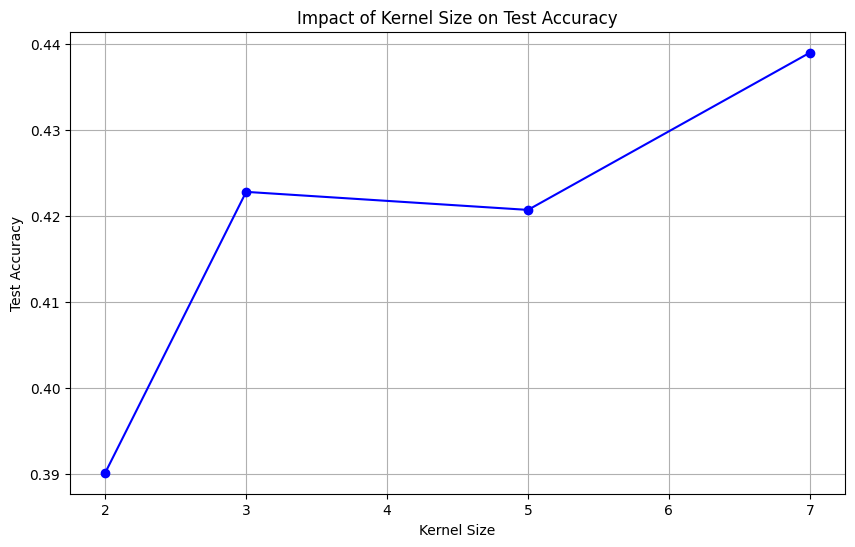

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Гиперпараметры
batch_size = 32
num_epochs = 20  # Уменьшил для ускорения экспериментов
pool_size = 2
conv_depth_1 = 32
conv_depth_2 = 64
drop_prob_1 = 0.25
drop_prob_2 = 0.5
hidden_size = 512

# Загрузка данных
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_train, height, width, depth = X_train.shape
num_classes = np.unique(y_train).shape[0]

# Нормализация данных
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot кодирование
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

# Исследование различных размеров ядра свертки
kernel_sizes = [2, 3, 5, 7]
results = []

for kernel_size in kernel_sizes:
    print(
        f"\n>>> Training with kernel size: {kernel_size}x{kernel_size} <<<\n")

    # Модель
    inp = Input(shape=(height, width, depth))  # CIFAR-10: (32, 32, 3)

    # Первый блок: Conv -> Conv -> Pool
    conv_1 = Conv2D(conv_depth_1, (kernel_size, kernel_size),
                    padding='same', activation='relu')(inp)
    conv_2 = Conv2D(conv_depth_1, (kernel_size, kernel_size),
                    padding='same', activation='relu')(conv_1)
    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
    drop_1 = Dropout(drop_prob_1)(pool_1)

    # Второй блок: Conv -> Conv -> Pool
    conv_3 = Conv2D(conv_depth_2, (kernel_size, kernel_size),
                    padding='same', activation='relu')(drop_1)
    conv_4 = Conv2D(conv_depth_2, (kernel_size, kernel_size),
                    padding='same', activation='relu')(conv_3)
    pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
    drop_2 = Dropout(drop_prob_1)(pool_2)

    # Flatten -> Dense -> Dropout -> Output
    flat = Flatten()(drop_2)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop_3 = Dropout(drop_prob_2)(hidden)
    out = Dense(num_classes, activation='softmax')(drop_3)

    model_kernel = Model(inputs=inp, outputs=out)
    model_kernel.compile(loss='categorical_crossentropy',
                         optimizer='adam', metrics=['accuracy'])

    # Обучение
    history_kernel = model_kernel.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                                      verbose=1, validation_split=0.1)

    # Оценка
    test_loss, test_accuracy = model_kernel.evaluate(X_test, Y_test, verbose=1)
    results.append({'kernel_size': kernel_size,
                   'test_accuracy': test_accuracy})
    print(
        f"Test accuracy with kernel size {kernel_size}x{kernel_size}: {test_accuracy:.4f}")

# Анализ результатов
print("\n>>> Results summary <<<")
for result in results:
    print(
        f"Kernel size {result['kernel_size']}x{result['kernel_size']}: Test Accuracy = {result['test_accuracy']:.4f}")

# Визуализация
kernel_sizes = [res['kernel_size'] for res in results]
accuracies = [res['test_accuracy'] for res in results]

plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, accuracies, marker='o', linestyle='-', color='b')
plt.title("Impact of Kernel Size on Test Accuracy")
plt.xlabel("Kernel Size")
plt.ylabel("Test Accuracy")
plt.grid()
plt.show()